# A small statistic on the use of bicycle-light in winter

The usage of bicycle light was studied on weekdays between 21.10.2020 and 08.03.2021.

Area of the survey: Bicycle Path between Karlsruhe and Ettlingen/Bruchhausen in Germany

Each morning, the bicycles with and without their lights on were counted manually by myself. The test route was always the same with a fixed starting and end point. There were little differences in time. The time of data collection was roughly between 8:00 am and 8:30 am, which is the time I needed for this trip by bicycle. The route is used by a lot of commuters, some bicycles were counted most days.

Dates without data collection can be explained by: 
* Weekends
* Holidays
* Snow
* Broken bicycle
* Getting confused by too many bikes to count at once
* Forgetting to count

Difficulties collecting the data:
* Bicycles with only one light on (back light or front light) were not considered, when noticed. Some cases like this might have been missed, therefore there might be cases in both groups.
* Very dim light
* Automatic light, which turns on when it is too dark, e.g. under a bridge
* People seen several times

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

from astral import LocationInfo
from astral.sun import sun
from pytz import timezone

## Preprocessing the data

The data was collected manually. Around Christmas, the first part of data was transfered to the computer and marked as checked in the app used for data collection. The time of arrival was only collected for 2021, except for one day in 2020, were the arrival was a bit later than usual.

In [2]:
df = pd.read_csv('data/Fahrrad_Licht_ohneLicht_2021-04-03_a', delim_whitespace=True)
df

,Fahrrad,Licht:ohne,Licht
1.0,08/03/2021,08:19:47,19:29
2.0,05/03/2021,08:31:26,23:13
3.0,04/03/2021,08:26:29,23:23
4.0,03/03/2021,08:31:40,21:31
5.0,02/03/2021,08:29:29,29:29
...,...,...,...
77.0,[✓],27/10/2020,29:26
78.0,[✓],26/10/2020,12:8
79.0,[✓],23.10.2020,27:11
80.0,[✓],22.10.2020,52:12


In [3]:
# Copy of the data to keep the original as is
df2 = df.copy()

In [4]:
# Rename the columns
df2.rename(columns={'Fahrrad': 'date', 'Licht:ohne': 'arrivaltime', 'Licht': 'with_without_light'}, inplace=True)

In [5]:
# Fill the date column with the actual date
df2.loc[df2.date=='[✓]','date']=df2['arrivaltime']

In [6]:
# Replace the NAN-values in arrivaltime with the approximate arrival time 8:30.
for index, value in enumerate(df2.arrivaltime):
    if '2020' in value:
        df2['arrivaltime'].iloc[index] = '08:30:00'

In [7]:
# Split the date and arrivaltime
for index, value in enumerate(df2.date):
    if '-' in value:
        df2['arrivaltime'].iloc[index] = value[-8:]
        df2['date'].iloc[index] = value[:10]

In [8]:
# Split the Column with_without_light into two columns 
df2 = df2.join(df2['with_without_light'].str.split(':', expand=True).rename(columns={0:'with_light', 1:'without_light'}))

In [9]:
# Change data types
df2['with_light'] = pd.to_numeric(df2['with_light'])
df2['without_light'] = pd.to_numeric(df2['without_light'])
df2['date'] = pd.to_datetime(df2['date'], format='%d/%m/%Y',
                              errors='coerce').fillna(pd.to_datetime(df2['date'], 
                                                                     format='%d.%m.%Y',errors='coerce'))
df2['arrivaltime'] = pd.to_datetime(df2['arrivaltime'], format='%H:%M:%S').dt.time

In [10]:
df2

,date,arrivaltime,with_without_light,with_light,without_light
1.0,2021-03-08,08:19:47,19:29,19,29
2.0,2021-03-05,08:31:26,23:13,23,13
3.0,2021-03-04,08:26:29,23:23,23,23
4.0,2021-03-03,08:31:40,21:31,21,31
5.0,2021-03-02,08:29:29,29:29,29,29
...,...,...,...,...,...
77.0,2020-10-27,08:30:00,29:26,29,26
78.0,2020-10-26,08:30:00,12:8,12,8
79.0,2020-10-23,08:30:00,27:11,27,11
80.0,2020-10-22,08:30:00,52:12,52,12


In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 81 entries, 1.0 to 81.0
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                81 non-null     datetime64[ns]
 1   arrivaltime         81 non-null     object        
 2   with_without_light  81 non-null     object        
 3   with_light          81 non-null     int64         
 4   without_light       81 non-null     int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 5.9+ KB


In [12]:
df2.describe()

,with_light,without_light
count,81.000000,81.000000
mean,29.172840,12.925926
std,10.771247,10.567376
min,5.000000,0.000000
25%,22.000000,4.000000
50%,28.000000,10.000000
75%,37.000000,23.000000
max,68.000000,39.000000


# Feature Engineering

In [13]:
# Calculate the sum of bicycles and the ratio of bicycles with light and without
df2['sum'] = df2['without_light'] + df2['with_light']
df2['ratio'] = df2['without_light']/df2['sum']

### Calculate difference between sunrise and arrivaltime

In [14]:
# Calculation of sunrise in Karlsruhe, Germany
df2['sunrise'] = ''
colindex = df2.columns.get_loc("sunrise")
city = LocationInfo("Karlsruhe", "Deutschland", "Europe/Berlin", 49.006889, 8.403653)
for index, value in enumerate(df2['date']):
    s = sun(city.observer, date=value, tzinfo=city.timezone)
    df2.iloc[index, colindex] = s['sunrise']

In [15]:
# Removal of timezone from sunrise to allow comparison with arrivaltime
df2['sunrise_without_timezone'] = ''
col_sunrise_wo_tz = df2.columns.get_loc("sunrise_without_timezone")
col_sunrise = df2.columns.get_loc("sunrise")

# Combine date and time of arrival to allow comparison with sunrise
df2['arrival_datetime'] = ''
col_arrival_datetime = df2.columns.get_loc("arrival_datetime")
for index in range(len(df2['date'])):
    # Remove timezone
    df2.iloc[index, col_sunrise_wo_tz] = df2.iloc[index, col_sunrise].replace(tzinfo=None)
    # Combine date and time of arrival
    df2.iloc[index, col_arrival_datetime] = dt.datetime.combine(df2.iloc[index, 0], df2.iloc[index, 1])

In [16]:
# Difference between time of arrival and sunrise
df2['sunrise_to_arrival'] = (df2['arrival_datetime'] - df2['sunrise_without_timezone'])

In [17]:
# Calender week and weekday
df2['week'] = ''
df2['day'] = ''
col_week = df2.columns.get_loc("week")
col_day = df2.columns.get_loc("day")
for index in range(len(df2['date'])):
    df2.iloc[index, col_week] = df2.iloc[index,0].isocalendar()[1]
    df2.iloc[index, col_day] = df2.iloc[index,0].isocalendar()[2]

In [18]:
df2.head()

,date,arrivaltime,with_without_light,with_light,without_light,sum,ratio,sunrise,sunrise_without_timezone,arrival_datetime,sunrise_to_arrival,week,day
1.0,2021-03-08,08:19:47,19:29,19,29,48,0.604167,2021-03-08 06:54:25.579966+01:00,2021-03-08 06:54:25.579966,2021-03-08 08:19:47,0 days 01:25:21.420034,10,1
2.0,2021-03-05,08:31:26,23:13,23,13,36,0.361111,2021-03-05 07:00:33.426453+01:00,2021-03-05 07:00:33.426453,2021-03-05 08:31:26,0 days 01:30:52.573547,9,5
3.0,2021-03-04,08:26:29,23:23,23,23,46,0.500000,2021-03-04 07:02:34.930661+01:00,2021-03-04 07:02:34.930661,2021-03-04 08:26:29,0 days 01:23:54.069339,9,4
4.0,2021-03-03,08:31:40,21:31,21,31,52,0.596154,2021-03-03 07:04:35.821162+01:00,2021-03-03 07:04:35.821162,2021-03-03 08:31:40,0 days 01:27:04.178838,9,3
5.0,2021-03-02,08:29:29,29:29,29,29,58,0.500000,2021-03-02 07:06:36.062514+01:00,2021-03-02 07:06:36.062514,2021-03-02 08:29:29,0 days 01:22:52.937486,9,2


## Diagrams

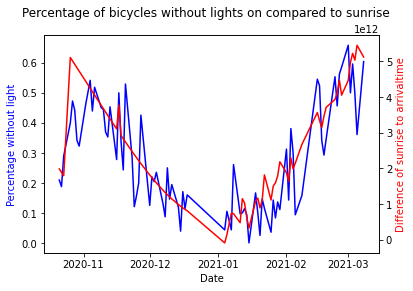

In [19]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot('date', 'ratio', data = df2, color='blue')
ax2.plot('date', 'sunrise_to_arrival', data = df2, color='red')

fig.suptitle('Percentage of bicycles without lights on compared to sunrise', fontsize=12)
ax1.set_xlabel('Date', fontsize=10)
ax1.set_ylabel('Percentage without light', fontsize=10, color='blue')
ax2.set_ylabel('Difference of sunrise to arrivaltime', fontsize=10, color='red')

plt.show()

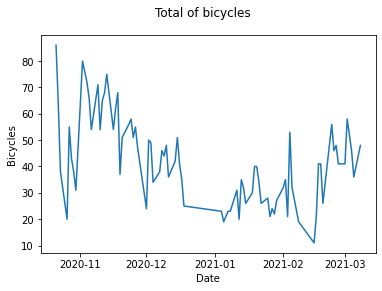

In [20]:
fig, ax = plt.subplots()
ax.plot('date', 'sum', data = df2)

fig.suptitle('Total of bicycles', fontsize=12)
ax.set_xlabel('Date', fontsize=10)
ax.set_ylabel('Bicycles', fontsize=10)

plt.show()

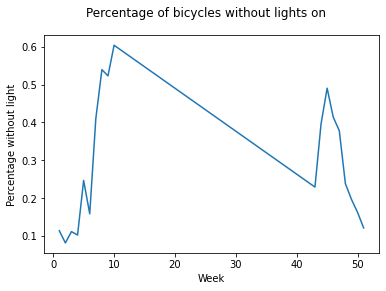

In [21]:
week_ratio = df2.groupby(['week']).mean()['ratio']

fig, ax = plt.subplots()
ax.plot(week_ratio)

fig.suptitle('Percentage of bicycles without lights on', fontsize=12)
ax.set_xlabel('Week', fontsize=10)
ax.set_ylabel('Percentage without light', fontsize=10)

plt.show()

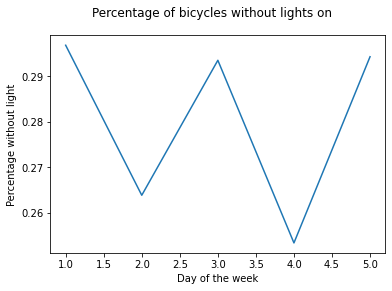

In [22]:
day_ratio = df2.groupby(['day']).mean()['ratio']

fig, ax = plt.subplots()
ax.plot(day_ratio)

fig.suptitle('Percentage of bicycles without lights on', fontsize=12)
ax.set_xlabel('Day of the week', fontsize=10)
ax.set_ylabel('Percentage without light', fontsize=10)

plt.show()

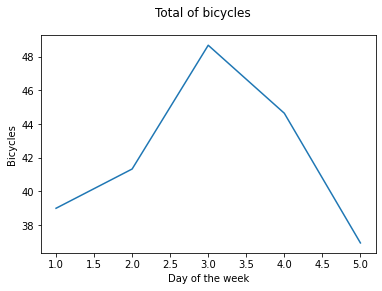

In [23]:
day_sum = df2.groupby(['day']).mean()['sum']

fig, ax = plt.subplots()
ax.plot(day_sum)

fig.suptitle('Total of bicycles', fontsize=12)
ax.set_xlabel('Day of the week', fontsize=10)
ax.set_ylabel('Bicycles', fontsize=10)

plt.show()